In [1]:
import numpy as np
import pynmea2
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


# Helpers
def text_to_bits(text, encoding='windows-1252', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

In [2]:
file_path = '../data/em31/0418-grids.R31'
r31_file = open(file_path, 'r', encoding='windows-1252')
r31_dat = r31_file.readlines()

In [4]:
# Get header data
if r31_dat[0].startswith('E'):
    h_ident = r31_dat[0][0:7] # System ident
    h_ver = r31_dat[0][8:12] # Software version
    h_type = r31_dat[0][12:15] # GPS or GRD (Grid)
    h_units = int(r31_dat[0][15:16]) # 0 = meter, 1 = feet
    h_dipole = int(r31_dat[0][16:17]) # 0 = vertical, 1 = horizontal
    h_mode = int(r31_dat[0][17:18]) # 0 = auto, 1 = wheel, 2 = manual
    h_component = int(r31_dat[0][18:19]) # 0 = Both, 1 = Iphase
    h_computer = int(r31_dat[0][22:23]) # no info on what this is
else:
    print('Error: First line is not a header')

In [5]:
# Get file data fields
if r31_dat[1].startswith('H'):
    h_file = r31_dat[1][2:11]
    h_time = r31_dat[1][13:18]

In [6]:
# Get file start stamp
if r31_dat[5].startswith('Z'):
    h_date = r31_dat[5][1:9]
    h_time = r31_dat[5][10:18]

In [23]:
# Get timer relation
if r31_dat[6].startswith('*'):
    epoch_time = r31_dat[6][1:13]
    epoch_ms = int(r31_dat[6][13:23])
epoch_ts = datetime.strptime(h_date + ' ' + epoch_time, '%d%m%Y %H:%M:%S.%f')

In [25]:
meas_idx = []; meas_df = pd.DataFrame()
for l_num, line in enumerate(r31_dat):
    if line.startswith('T'):
        meas_idx.append(l_num)
        meas_gn = text_to_bits(line[1])
        meas_range3 = int(meas_gn[5])
        meas_range2 = int(meas_gn[6])
        
        meas_read1 = float(line[2:7])
        meas_read2 = float(line[7:12])
        meas_time = int(line[13:23])
        
        if (meas_range2 == 1) and (meas_range3 == 1):
            c_factor = -0.25
            i_factor = -0.0025
            conductivity =  meas_read1 * c_factor
            inphase = meas_read2 * i_factor
        else:
            conductivity = np.nan
            
        meas_df = meas_df.append({'time_ms': meas_time,
                                  'flags': meas_gn,
                                  'range2': meas_range3,
                                  'range3': meas_range3,
                                  'c_factor': c_factor,
                                  'conductivity': conductivity,
                                  'inphase': inphase}, ignore_index = True)    

In [26]:
# Create measurement time stamps
meas_df['time_relative'] = meas_df['time_ms'] - epoch_ms
meas_df['time_ds'] = np.repeat(epoch_ts, len(meas_df)) + [timedelta(milliseconds=rel) for rel in meas_df['time_relative']]

In [71]:
meas_df

,c_factor,conductivity,flags,inphase,range2,range3,time_ms,time_relative,time_ds
0,-0.25,21.25,10000110,20.4775,1.0,1.0,76443268.0,2587.0,2016-04-18 07:51:39.743
1,-0.25,21.25,10000110,20.4775,1.0,1.0,76444263.0,3582.0,2016-04-18 07:51:40.738
2,-0.25,21.25,10000110,20.4775,1.0,1.0,76445259.0,4578.0,2016-04-18 07:51:41.734
3,-0.25,21.50,10000110,20.4775,1.0,1.0,76446254.0,5573.0,2016-04-18 07:51:42.729
4,-0.25,21.25,10000110,20.4775,1.0,1.0,76447250.0,6569.0,2016-04-18 07:51:43.725
...,...,...,...,...,...,...,...,...,...
13828,-0.25,-0.75,10000110,20.4775,1.0,1.0,90209077.0,13768396.0,2016-04-18 11:41:05.552
13829,-0.25,-0.75,10000110,20.4775,1.0,1.0,90210068.0,13769387.0,2016-04-18 11:41:06.543
13830,-0.25,-0.75,10000110,20.4775,1.0,1.0,90211060.0,13770379.0,2016-04-18 11:41:07.535
13831,-0.25,-1.00,10000110,20.4775,1.0,1.0,90212050.0,13771369.0,2016-04-18 11:41:08.525


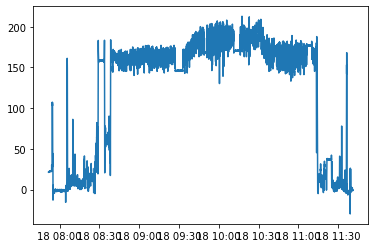

In [27]:
plt.plot(meas_df['time_ds'], meas_df['conductivity'])

In [29]:
r31_gps = r31_dat
for index in sorted(meas_idx, reverse=True):
    del r31_gps[index]

In [60]:
count = 0
gps_sentances = []; gps_sys_ts = []
for num, line in enumerate(r31_gps):
    if line.startswith('@'):
        count = count + 1
        # Find the GPS ending line (No more than 6 away)
        gps_end = [l.startswith('!') for l in r31_dat[num:num+6]]
        gps_end_idx = int(num + np.where(gps_end)[0])
        #Parse the GPS data
        gps_data = r31_dat[num:gps_end_idx]
        gps_data_clean = [dat[1:-1] for dat in gps_data]
        gps_data_str = ''.join(gps_data_clean).strip()
        try:
            gps_msg = pynmea2.parse(gps_data_str)
        except:
            print('bad gps encoding')
            
        if isinstance(gps_msg, pynmea2.types.talker.GGA):
            gps_end_line = r31_dat[gps_end_idx]
            gps_sys_ms = int(gps_end_line[13:23])
            gps_sys_rel = gps_sys_ms - epoch_ms
            gps_sys_ts.append(epoch_ts + timedelta(milliseconds=gps_sys_rel))
            gps_sentances.append(gps_msg)

In [73]:
gps_df = pd.DataFrame()
for sidx, msg in enumerate(gps_sentances):
    gps_df = gps_df.append({'time_sys':gps_sys_ts[sidx],
                            'time_gps':msg.timestamp,
                            'fix': msg.gps_qual,
                            'nsats': msg.num_sats,
                            'hdop': msg.horizontal_dil,
                            'alt': msg.altitude,
                            'lat': msg.latitude,
                            'lat_dir': msg.lat_dir,
                            'lon': msg.longitude,
                            'lon_dir': msg.lon_dir}, ignore_index = True)

In [86]:
# Drop bad GPS data
gps_df = gps_df.loc[(gps_df['fix'] > 0) & (gps_df['fix'] <6)]

In [90]:
gps_df.columns

Index(['alt', 'fix', 'hdop', 'lat', 'lat_dir', 'lon', 'lon_dir', 'nsats',
       'time_gps', 'time_sys'],
      dtype='object')

In [ ]:
pd.merge_asof(df_obs, df_cont[['lat', 'long', 'alt', 'time']], 
              left_on='ts', right_on='time', direction='nearest')

In [93]:
em31_merged = pd.merge_asof(meas_df, gps_df[['lat', 'lon', 'time_gps', 'time_sys']], 
                            left_on='time_ds', right_on='time_sys', direction='nearest')

In [96]:
time_diff = em31_merged['time_ds'] - em31_merged['time_sys']

Timestamp('2016-04-18 07:51:39.743000')

In [112]:
time_diff = em31_merged['time_sys'] - em31_merged['time_ds']

In [115]:
em31_clean = em31_merged.loc[time_diff < timedelta(seconds=1)]

In [135]:
y = (-1/0.826)*np.log((em31_clean['conductivity']-13.404)/1366.4)

In [136]:
x = -(10000*np.log((5*em31_clean['conductivity']-67)/6832))/9823

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   3.,   0.,   5.,   3.,  12.,  26.,  26.,  45.,  58.,  96.,
         89., 188., 104., 217., 173., 

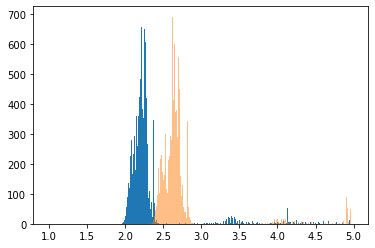

In [137]:
bins = np.arange(1, 5, 0.01)
plt.hist(x, bins = bins)
plt.hist(y, bins = bins, alpha = 0.5)

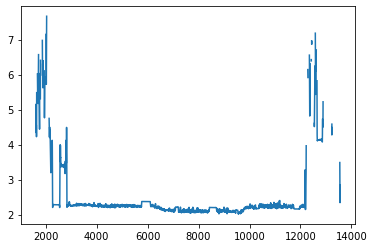

In [144]:
plt.plot(x.rolling(10).mean())

1439    NaN
1440    NaN
1441    NaN
1442    NaN
1443    NaN
         ..
13828   NaN
13829   NaN
13830   NaN
13831   NaN
13832   NaN
Name: conductivity, Length: 12379, dtype: float64